In [1]:
import numpy as np
import matplotlib.pyplot as plit
from skimage import io
from skimage import color
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.feature import match_descriptors


In [2]:
class Stitch():
    def __init__(self):
        pass
    def stitcher(self, img_arr_3):
        keypoint_and_descriptors = []
        matches=[]
        robust_inliers=[]
        warped_corners=[]
        warped_images=[]
        masked_images=[]
        transforms=[]
        #Loading Images and turning to rgb
        y =lambda x: color.rgb2gray(io.imread(x))
        x = list(map(y, img_arr_3))
        r, c = x[0].shape[:2]
        corners = np.array([[0, 0],[0, r], [c, 0], [c, r]])
        #Creating ORB Instance
        orb = ORB(n_keypoints=2000, fast_threshold= 0.08)
        #fetching ORB keypoints and descriptors
        for img in x:
            orb.detect_and_extract(img)
            keypoint_and_descriptors.append((orb.keypoints, orb.descriptors))
        #Matching the features in two pair of the images   
        matches01= match_descriptors(keypoint_and_descriptors[0][1], keypoint_and_descriptors[1][1], cross_check=True)
        matches12= match_descriptors(keypoint_and_descriptors[1][1], keypoint_and_descriptors[2][1], cross_check=True)
        #We use the RANSAC algorithm to remove the extra features
        src = keypoint_and_descriptors[0][0][matches01[:, 0]][:, ::-1]
        dst = keypoint_and_descriptors[1][0][matches01[:, 1]][:, ::-1]
        model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=300)
        robust_inliers.append((model_robust01, inliers01))
        
        src = keypoint_and_descriptors[1][0][matches12[:, 1]][:, ::-1]
        dst = keypoint_and_descriptors[0][0][matches12[:, 0]][:, ::-1]
        model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=300)
        robust_inliers.append((model_robust12, inliers12))

        #Warping the Images to stitch together
        
        for _ in robust_inliers:
            warped_corners.append(_[0](corners))
        # Find the extents of both the reference image and the warped
        # target image
        all_corners = np.vstack((warped_corners[0], warped_corners[1], corners))
        # The overally output shape will be max - min
        corner_min = np.min(all_corners, axis=0)
        corner_max = np.max(all_corners, axis=0)
        output_shape = (corner_max - corner_min)
        # Ensure integer shape with np.ceil and dtype conversion
        output_shape = np.ceil(output_shape[::-1]).astype(int)
        offset1 = SimilarityTransform(translation= -corner_min)
        transform01 = (robust_inliers[0][0] + offset1).inverse
        image1_warped = warp(x[0], transform01, order=3,output_shape=output_shape, cval=-1)
        image1_mask = (image1_warped != -1)  # Mask == 1 inside image
        image1_warped[~image1_mask] = 0      # Return background values to 0
        image2_warped = warp(x[1], offset1.inverse, order=3, output_shape=output_shape, cval=-1)
        image2_mask = (image2_warped != -1)  # Mask == 1 inside image
        image2_warped[~image2_mask] = 0      # Return background values to 0
        transform12 = (robust_inliers[1][0] + offset1).inverse
        image3_warped = warp(x[2], transform12, order=3, output_shape=output_shape, cval=-1)
        image3_mask = (image3_warped != -1)  # Mask == 1 inside image
        image3_warped[~image3_mask] = 0
        merged = (image1_warped + image2_warped + image3_warped)
        overlap = (image1_mask* 1.0 + image2_mask + image3_mask)
        normalized = merged / np.maximum(overlap, 1)
        return normalized

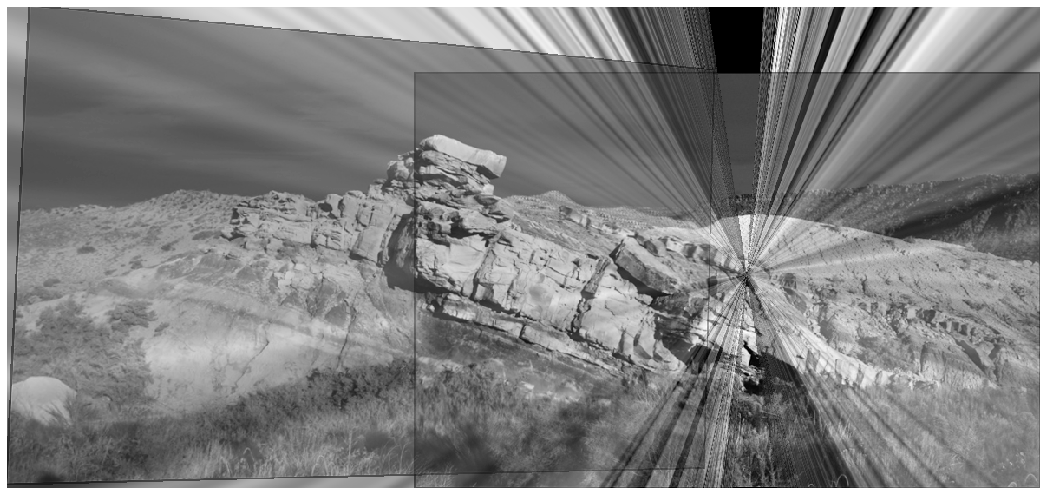

In [3]:
import skimage
import matplotlib.pyplot as plt
instance = Stitch()
result= instance.stitcher(["1.jpg","2.jpg","3.jpg"])
fig, ax = plt.subplots(figsize=(15, 12))
ax.imshow(result, cmap='gray')
fig.savefig("OUT.jpeg")
plt.tight_layout()
ax.axis('off');
